# Notebook Energy Consumption

This notebook has the objective to explore the data and create a model to predict the energy consumption and CO2 emissions of a building, based on its characteristics. Then a suggestion of upgrades will be made to reduce the energy consumption and CO2 emissions.

Summary :
- Data Exploration
- Feature Extraction
- Model Creation
- Upgrades Suggestion

## Imports

In [89]:
!pip install xgboost
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, coverage_error, f1_score, mean_absolute_error, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("base_IledeFrance.csv")

## <b><div style='padding:15px;background-color:#003f88;color:white;border-radius:2px;font-size:110%;text-align: center'>1  |  Data Exploration</div></b>

In this section, the data will be explored to understand the data and its characteristics.

In [8]:
df.describe()

,Unnamed: 0,code_departement_insee,dpe_id,baie_fs,baie_u,conso_ener,estim_ges,mur_u_ext,pb_u,prc_s_vitree_ext,ph_u,s_hab,ratio_ges_conso
count,43005.0000,43005.0,4.300500e+04,24506.000000,25053.000000,43005.000000,43005.000000,24995.000000,23736.000000,22879.000000,24350.000000,42989.000000,38917.000000
mean,21502.0000,95.0,4.441258e+06,0.562375,2.638769,237.758315,34.660139,0.812803,0.877322,0.182803,0.570315,116.675801,0.152226
std,12414.6185,0.0,2.719284e+06,0.984195,0.698822,158.883999,31.342915,0.612149,0.705527,0.106426,0.731348,279.528252,0.093098
min,0.0000,95.0,3.750000e+02,0.010000,0.200000,-68.320000,0.000000,0.060000,0.070000,0.000000,0.050000,0.000000,-0.290000
25%,10751.0000,95.0,2.058362e+06,0.440000,2.200000,159.730000,11.000000,0.360000,0.350000,0.117000,0.200000,68.000000,0.050000
50%,21502.0000,95.0,4.339833e+06,0.470000,2.500000,228.020000,26.000000,0.470000,0.520000,0.156000,0.250000,93.000000,0.190000
75%,32253.0000,95.0,6.712464e+06,0.497500,2.900000,311.340000,52.000000,0.980000,2.000000,0.215000,0.430000,122.000000,0.230000
max,43004.0000,95.0,9.431150e+06,127.970000,6.200000,12880.060000,902.830000,2.860000,3.200000,0.947000,3.900000,16155.000000,0.480000


Here's the distribution of current numerical data.

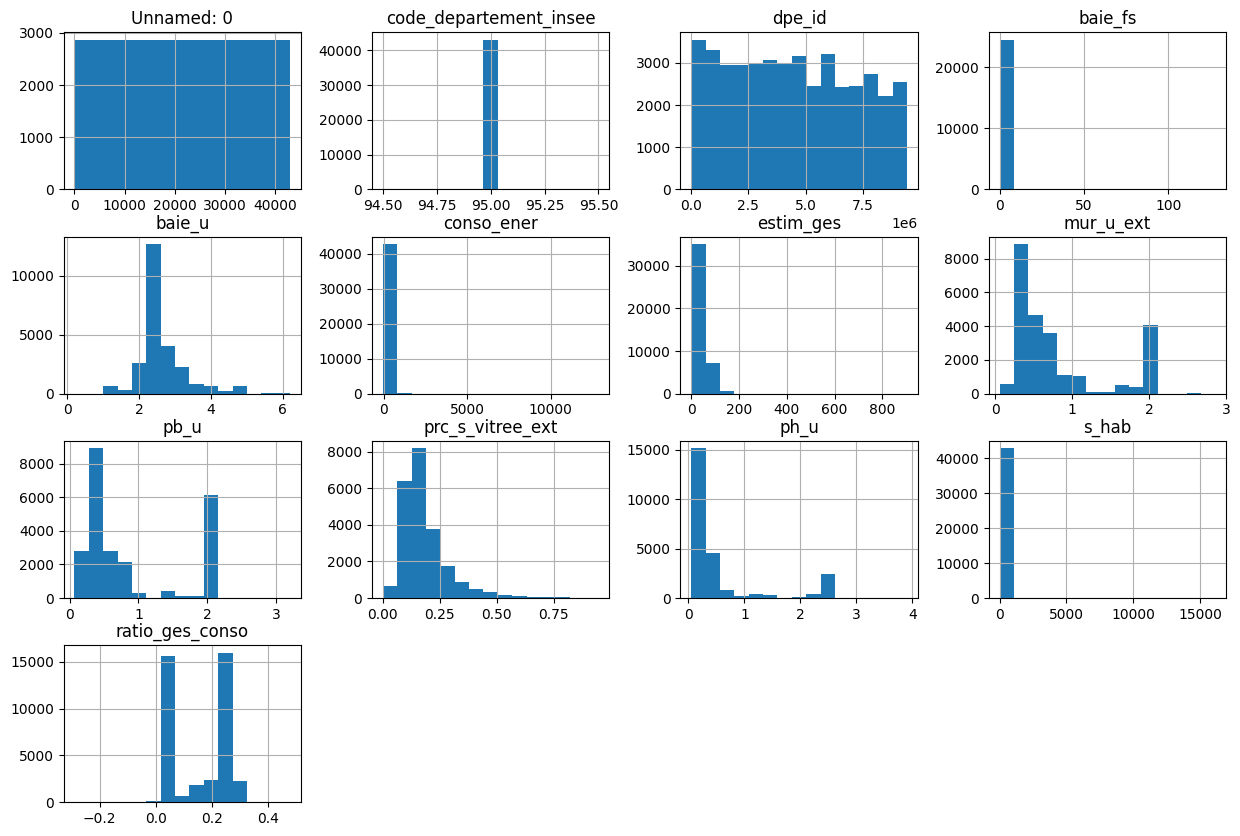

In [9]:
%matplotlib inline
df.hist(bins=15, figsize=(15, 10))
plt.show()

The dataset is unbalanced, with the 4th class being the most represented. We will need to take this into account when training our model.

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>1.1 |</span><span style='color:#003f88'> Features Descriptions</span></b>
</div>
<div style="display: flex;">
    <!-- First Column -->
    <div style="flex: 1; padding-right: 10px;">
        <!-- First column content -->
        <b>baie_fs:</b> Window solar factor.<br>
        <b>baie_mat:</b> Window frame material.<br>
        <b>baie_remplissage:</b> Type of window infill.<br>
        <b>baie_type_vitrage:</b> Type of window glazing.<br>
        <b>baie_u:</b> Thermal transmittance of the window.<br>
        <b>ch_gen_lib, ch_gen_lib_appoint, ch_gen_lib_princ:</b> Characteristics of the heating system.<br>
        <b>ch_solaire:</b> Presence of solar heating.<br>
        <b>ch_type_ener_corr:</b> Type of energy used for heating.<br>
        <b>type_ventilation:</b> Type of ventilation system, which affects air exchanges and energy use.<br>
        <b>ratio_ges_conso:</b> Ratio of greenhouse gas emissions to energy consumption.<br>
    </div>
    <!-- Second Column -->
    <div style="flex: 1; padding-right: 10px;">
        <!-- Second column content -->
        <b>ch_type_inst:</b> Type of heating installation.<br>
        <b>ecs_gen_lib, ecs_gen_lib_appoint, ecs_gen_lib_princ:</b> Characteristics of the hot water system.<br>
        <b>ecs_solaire:</b> Presence of solar hot water.<br>
        <b>ecs_type_ener:</b> Type of energy used for hot water.<br>
        <b>ecs_type_inst:</b> Type of hot water installation.<br>
        <b>enr:</b> Use of renewable energy.<br>
        <b>mur_ep_mat_ext:</b> External wall insulation thickness and material.<br>
        <b>mur_mat_ext:</b> External wall material.<br>
        <b>classe_conso_ener:</b> Energy consumption class.<br>
        <b>classe_estim_ges:</b> Estimated greenhouse gas class.<br>
        <b>conso_ener:</b> Actual energy consumption.<br>
    </div>
    <!-- Third Column -->
    <div style="flex: 1;">
        <!-- Third column content -->
        <b>mur_pos_isol_ext:</b> Position of external wall insulation.<br>
        <b>mur_u_ext:</b> Thermal transmittance of the external wall.<br>
        <b>pb_mat:</b> Floor/ceiling material.<br>
        <b>pb_pos_isol:</b> Insulation position in floors/ceilings.<br>
        <b>pb_type_adjacence:</b> Type of adjacency related to floors/ceilings.<br>
        <b>pb_u:</b> Thermal transmittance of floors/ceilings.<br>
        <b>ph_mat:</b> Roof material.<br>
        <b>ph_pos_isol:</b> Roof insulation position.<br>
        <b>ph_type_adjacence:</b> Type of adjacency related to the roof.<br>
        <b>ph_u:</b> Thermal transmittance of the roof.<br>
        <b>presence_climatisation:</b> Presence and type of air conditioning system.<br>
        <b>s_hab:</b> Habitable surface area.<br>
        <b>type_batiment:</b> Type of building, as different types may have different energy consumption p consumption.<br>
    </div>
</div>

## <b><div style='padding:15px;background-color:#003f88;color:white;border-radius:2px;font-size:110%;text-align: center'>2  |  Features Extraction</div></b>

We select all the features that can be modified by the client in order to upgrade its building's energy comsumption and efficiency.

In [3]:
relevant_features = [
    'baie_fs', 'baie_mat', 'baie_remplissage', 'baie_type_vitrage', 'baie_u',
    'ch_gen_lib', 'ch_gen_lib_appoint', 'ch_gen_lib_princ', 'ch_solaire', 'ch_type_ener_corr', 'ch_type_inst',
    'ecs_gen_lib', 'ecs_gen_lib_appoint', 'ecs_gen_lib_princ', 'ecs_solaire', 'ecs_type_ener', 'ecs_type_inst',
    'enr',
    'mur_ep_mat_ext', 'mur_mat_ext', 'mur_pos_isol_ext', 'mur_u_ext',
    'pb_mat', 'pb_pos_isol', 'pb_type_adjacence', 'pb_u',
    'ph_mat', 'ph_pos_isol', 'ph_type_adjacence', 'ph_u',
    'presence_climatisation',
    's_hab', 'type_batiment', 'type_ventilation',
    'ratio_ges_conso', 'classe_conso_ener', 'classe_estim_ges', 'conso_ener'
]

df_prepro = df[relevant_features]

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoders = []
df_encoded = df_prepro.copy()

for column in df_encoded.select_dtypes(include=['object', 'int', 'bool']).columns:
    label_encoder = LabelEncoder()
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    label_encoders.append((column, label_encoder))

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>2.1 |</span><span style='color:#003f88'> Correlation Matrix</span></b>
</div>

In this section, we will explore the correlation between the features and the target variable.

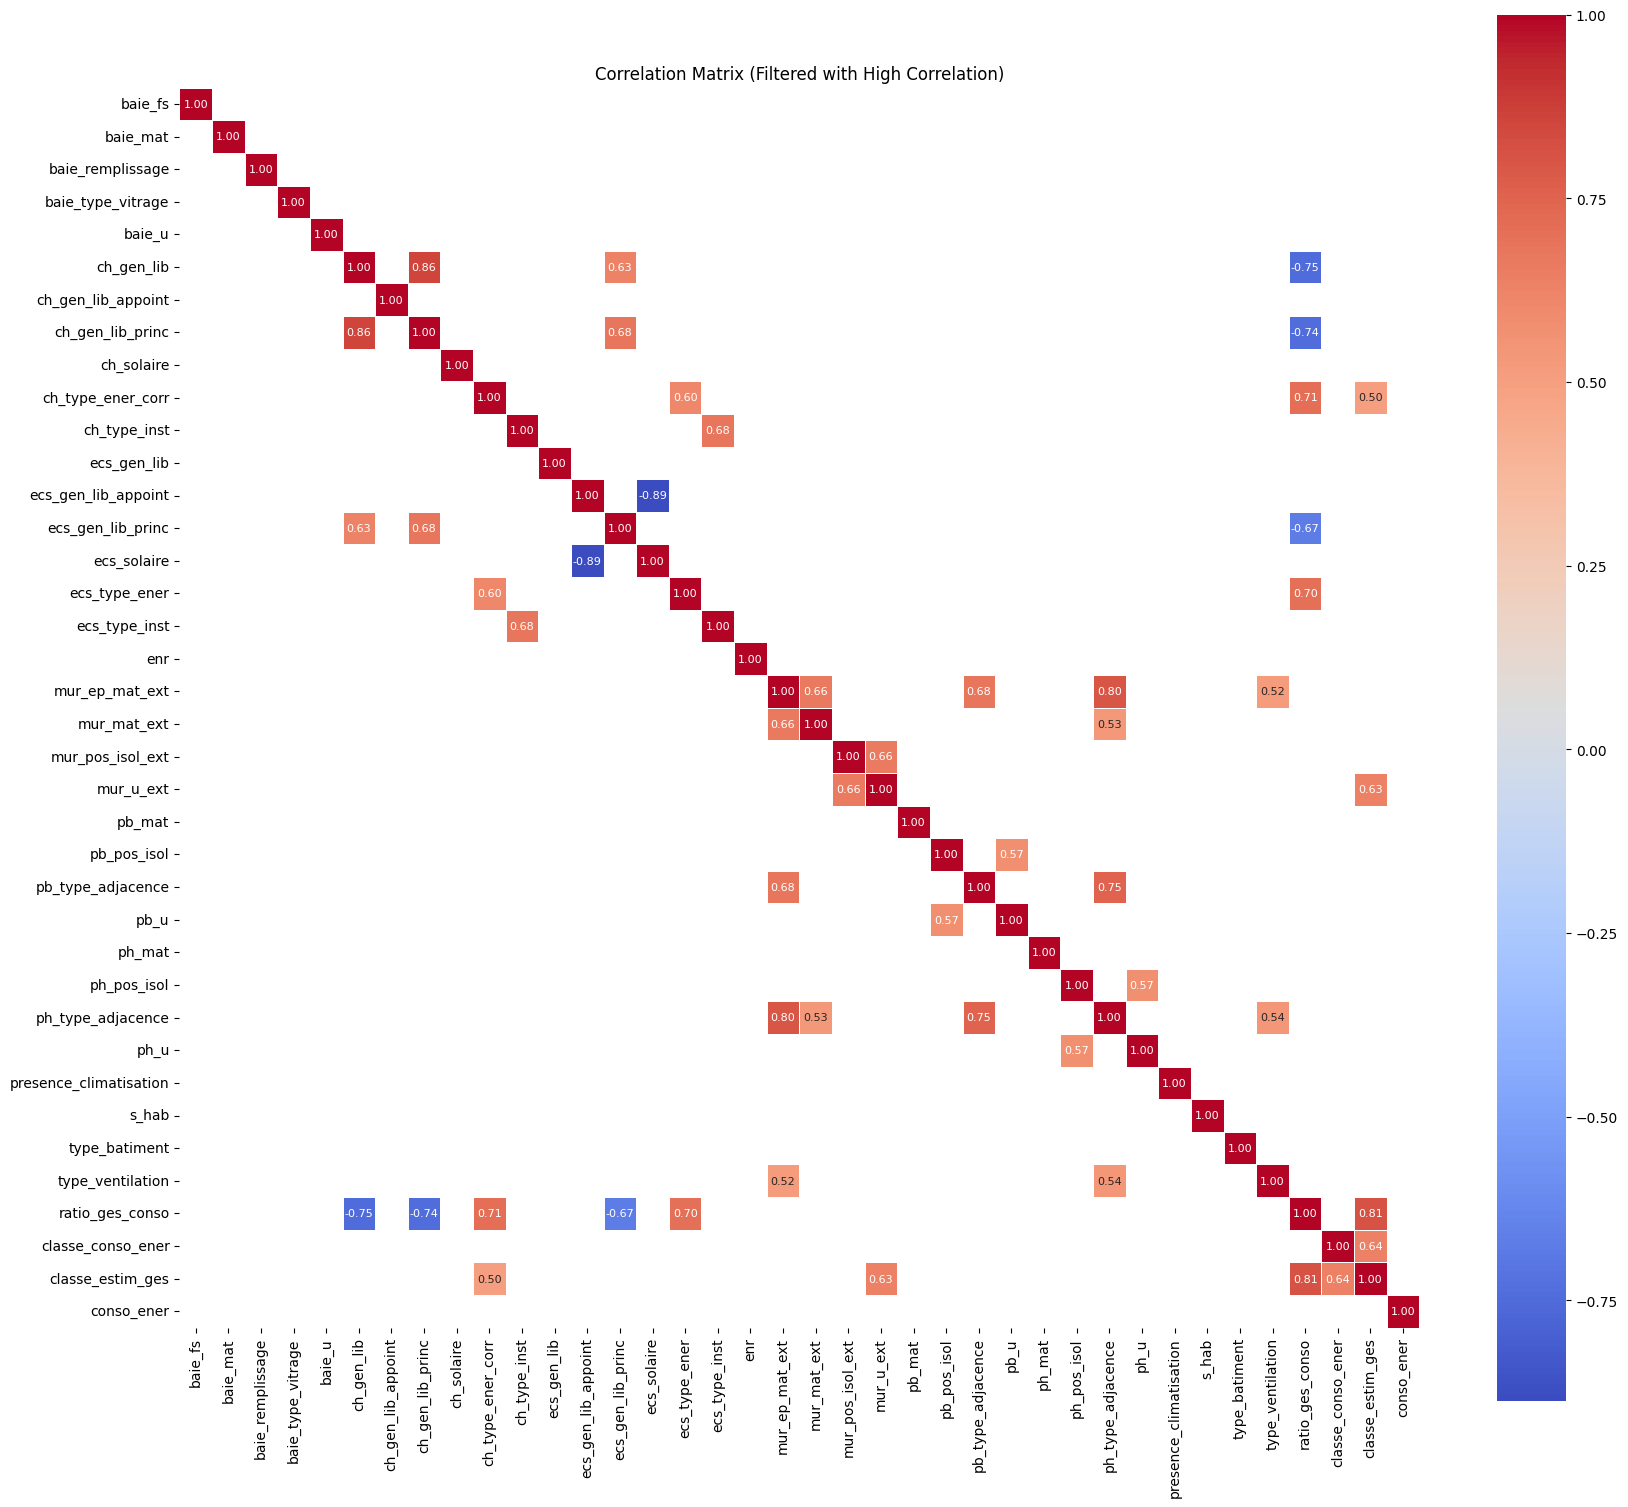

In [12]:
correlation_matrix = df_encoded.corr()
threshold = 0.5
filtered_corr = correlation_matrix.where(abs(correlation_matrix) > threshold)
plt.figure(figsize=(20, 18))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 8})
plt.title('Correlation Matrix (Filtered with High Correlation)')
plt.show()

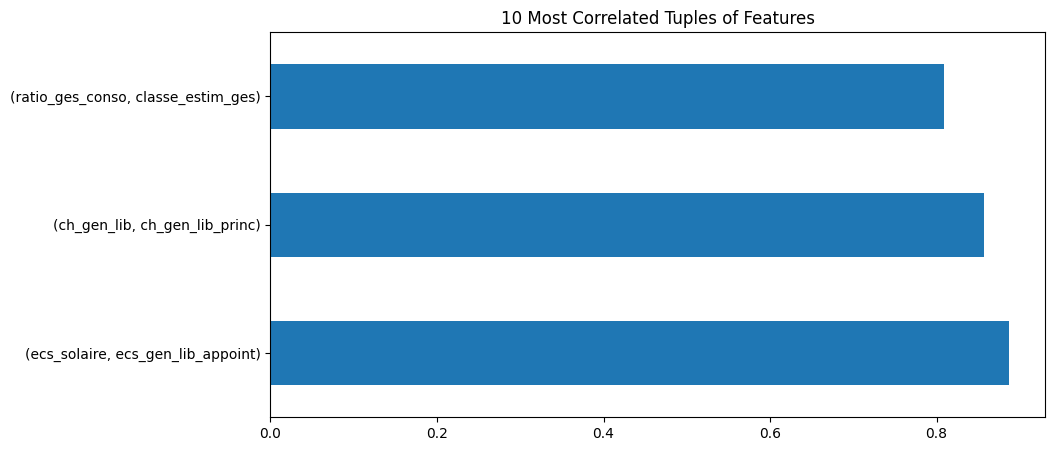

In [13]:
# plot the k most correlated tuples of features in a bar plot without the same features
k = 5
corr = df_encoded.corr().abs()
s = corr.unstack()
s = s[s != 1]
so = s.sort_values(kind="quicksort", ascending=False)
so = so[so > 0.8]
so = so[so < 1]
so = so[::2]
so = so[:k]
so.plot(kind="barh", figsize=(10, 5))
plt.title('10 Most Correlated Tuples of Features')
plt.show()

We can see from the correlation matrix some features that are highly correlated with the target variable. We will use these features to train our model.
However we can also notice that ```(ch_gen_lib, ch_gen_lib_princ)``` and ```(ecs_solaire, ecs_gen_lib_appoint)``` are highly correlated. We will only keep one of these features to avoid overfitting.

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>2.2 |</span><span style='color:#003f88'> Principal component analysis</span></b>
</div>

To enforce the features choice we perform a PCA to to see which component is the most influent for the energy comsuption rating. With that piece of information we will be able to know which component needs to change first.

In [5]:
df_encoded = df_encoded.fillna(df_encoded.mean())

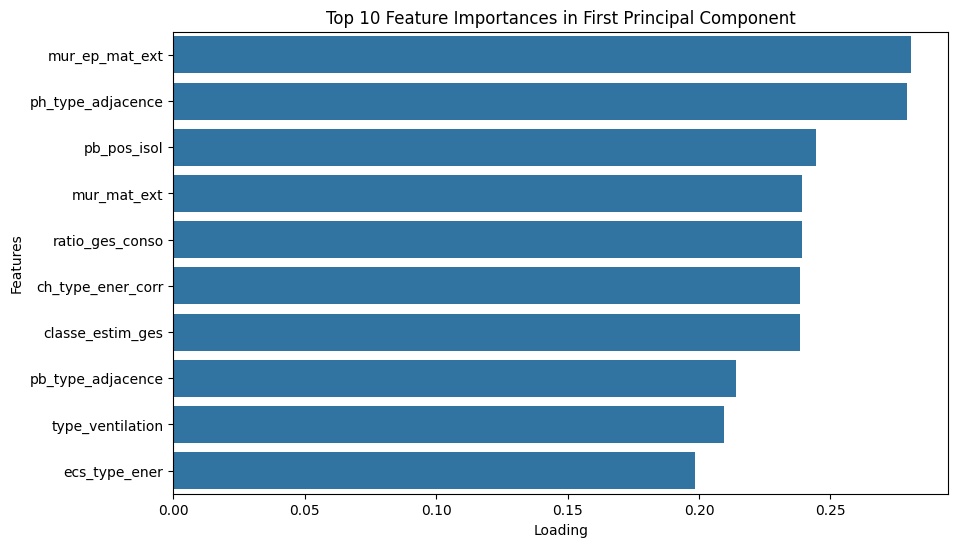

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_encoded)

pca = PCA()
principal_components = pca.fit_transform(df_standardized)

# Get the loadings for the first principal component
loadings = pca.components_[0]

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, index=df_encoded.columns, columns=['Loading'])

# Sort the loadings and select the top 10
top_10_features = loadings_df.nlargest(10, 'Loading')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_features, x='Loading', y=top_10_features.index)
plt.title('Top 10 Feature Importances in First Principal Component')
plt.xlabel('Loading')
plt.ylabel('Features')
plt.show()

## <b><div style='padding:15px;background-color:#003f88;color:white;border-radius:2px;font-size:110%;text-align: center'>3  |  Model Creation</div></b>

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.1 |</span><span style='color:#003f88'> Normalize the datas</span></b>
</div>

We normalize the data to avoid biases and get a faster training speed.

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize_float_columns(df):
    float_cols = df.select_dtypes(include=['float64', 'float32']).columns
    columns_to_scale = [col for col in float_cols if col not in ['classe_conso_ener', 'classe_estim_ges']]
    scaler = MinMaxScaler()
    df[float_cols] = scaler.fit_transform(df[columns_to_scale])
    return df

# Normalize using Standard Scaler
df_encoded = normalize_float_columns(df_encoded)
df_encoded

,baie_fs,baie_mat,baie_remplissage,baie_type_vitrage,baie_u,ch_gen_lib,ch_gen_lib_appoint,ch_gen_lib_princ,ch_solaire,ch_type_ener_corr,...,ph_type_adjacence,ph_u,presence_climatisation,s_hab,type_batiment,type_ventilation,ratio_ges_conso,classe_conso_ener,classe_estim_ges,conso_ener
0,0.004317,0,0,1,0.406462,169,26,12,0,33,...,4,0.135147,0,0.003405,3,12,0.675325,4,5,0.024150
1,0.004317,7,2,1,0.406462,405,26,19,0,24,...,4,0.135147,0,0.004024,3,15,0.415584,5,2,0.033156
2,0.004317,7,1,1,0.406462,131,26,11,0,33,...,4,0.135147,0,0.004024,0,11,0.675325,1,2,0.010673
3,0.003282,0,0,1,0.400000,216,20,19,0,11,...,2,0.033766,0,0.009285,3,5,0.441558,4,2,0.024120
4,0.003360,7,2,1,0.316667,219,26,19,0,24,...,1,0.038961,0,0.005138,3,2,0.454545,4,2,0.029140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43000,0.003673,7,0,1,0.416667,419,26,30,0,37,...,1,0.064935,0,0.003900,2,3,0.415584,3,1,0.019664
43001,0.003673,7,0,1,0.283333,419,26,30,0,37,...,1,0.064935,0,0.003466,2,10,0.415584,3,0,0.019054
43002,0.003048,7,0,1,0.383333,169,26,12,0,33,...,1,0.036364,0,0.003714,0,2,0.675325,5,6,0.033367
43003,0.003673,7,0,1,0.266667,415,3,30,0,37,...,1,0.057143,0,0.004147,2,10,0.454545,2,0,0.012544


<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.2 |</span><span style='color:#003f88'> Prepare the dataset</span></b>
</div>

Let's remove the labels from the dataset and split it into a training and a testing set, for DPE and GES.

In [8]:
to_hide = ['classe_conso_ener', 'classe_estim_ges', 'classe_estim_ges', 'conso_ener', 'ratio_ges_conso']

In [9]:
X_train_dpe, X_test_dpe, y_train_dpe, y_test_dpe = train_test_split(df_encoded.drop(columns=to_hide), df_encoded[['classe_conso_ener']],test_size = 0.2)
X_train_ges, X_test_ges, y_train_ges, y_test_ges = train_test_split(df_encoded.drop(columns=to_hide), df_encoded[['classe_estim_ges']],test_size = 0.2)

In [10]:
# get classes from y_train
classes_dpe = y_train_dpe['classe_conso_ener'].unique()
classes_dpe.sort()

classes_ges = y_train_ges['classe_estim_ges'].unique()
classes_ges.sort()

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.3 |</span><span style='color:#003f88'> Train the model</span></b>
</div>

Let's apply XGBoost to train our model using class weights to take into account the unbalanced dataset.

In [11]:
from sklearn.utils import class_weight

class_weights_dpe = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_dpe['classe_conso_ener']
)

class_weights_ges = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_ges['classe_estim_ges']
)

In [12]:
import xgboost as xgb

model_dpe = xgb.XGBClassifier(random_state=42, device='gpu')
model_dpe.fit(X_train_dpe, y_train_dpe, sample_weight=class_weights_dpe)

model_ges = xgb.XGBClassifier(random_state=42, device='gpu')
model_ges.fit(X_train_ges, y_train_ges, sample_weight=class_weights_ges)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
# balanced accuracy
from sklearn.metrics import balanced_accuracy_score

predictions_dpe = model_dpe.predict(X_test_dpe)
accuracy_dpe = balanced_accuracy_score(y_test_dpe, predictions_dpe)
print(f"Balanced accuracy DPE: {accuracy_dpe}")

predictions_ges = model_ges.predict(X_test_ges)
accuracy_ges = balanced_accuracy_score(y_test_ges, predictions_ges)
print(f"Balanced accuracy GES: {accuracy_ges}")

Balanced accuracy DPE: 0.6161939033521434
Balanced accuracy GES: 0.6337374564759071


/home/yoku/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:14:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


As we can see the model is 60% accurate, which is not great. However this is the accuracy metric and that doesn't take into account "error distance".

<div style="margin-bottom: 20px;">
    <b><span style='color:#DEB078'>3.4 |</span><span style='color:#003f88'> Evaluate the model</span></b>
</div>

A better way of evaluating this is by using a confusion matrix.

DPE


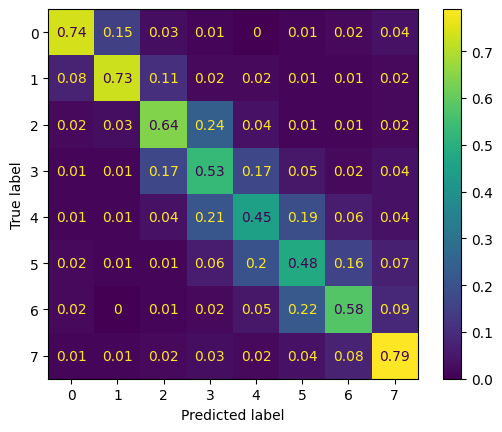

GES


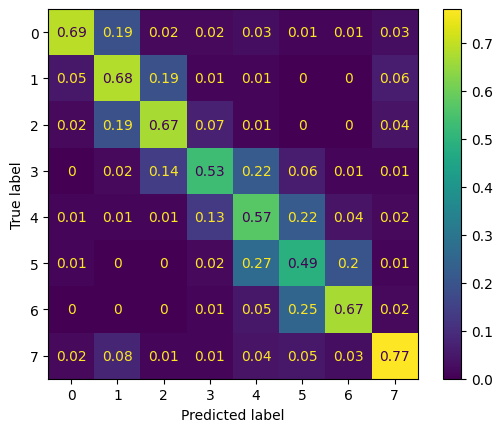

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(model, y_test, y_pred):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.round(cm_normalized, 2)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)
    disp.plot()
    plt.show()

print("DPE")
plot_cm(model_dpe, y_test_dpe, predictions_dpe)
print("GES")
plot_cm(model_ges, y_test_ges, predictions_ges) 

We can clearly see the diagonal line is quite pronounced, which is a good sign, our model isn't as underperforming as we thought.

Let's take a look at which features the models thought were the most important.

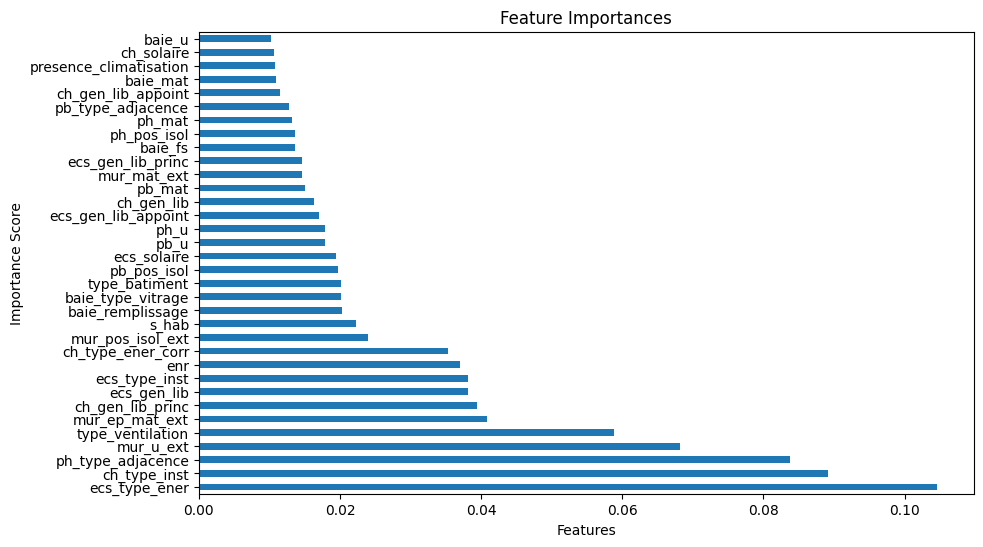

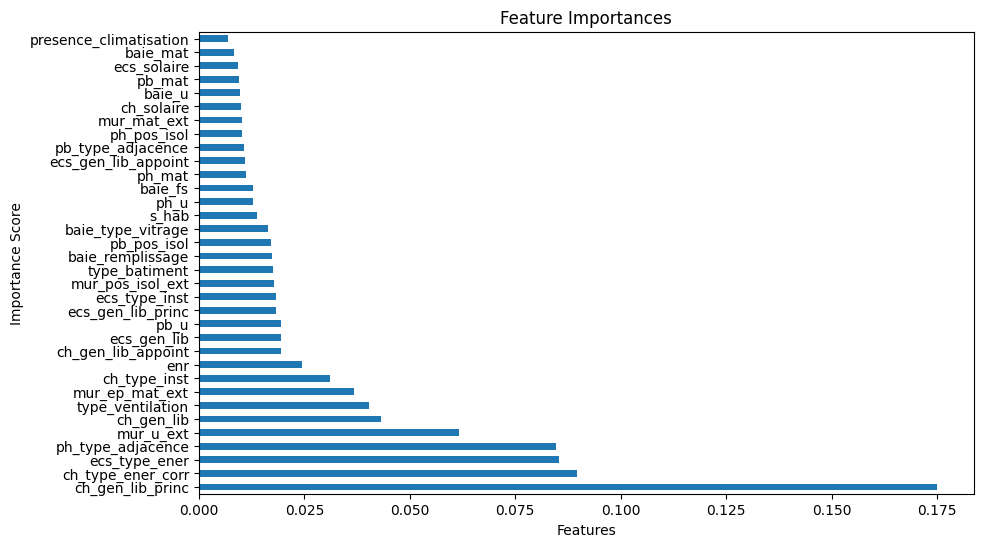

In [15]:
def fi(model, X_train):
    # Get feature importances
    feature_importances = model.feature_importances_
    
    
    # Create a pandas Series for easier visualization
    importance_series = pd.Series(feature_importances, index=X_train.columns)
    
    # Sort the features by their importance
    sorted_importance = importance_series.sort_values(ascending=False)
    
    # Plotting
    plt.figure(figsize=(10,6))
    sorted_importance.plot(kind='barh')
    plt.title('Feature Importances')
    plt.ylabel('Importance Score')
    plt.xlabel('Features')
    plt.show()

fi(model_dpe,X_train_dpe)
fi(model_ges,X_train_ges)

It's pretty clear that in the DPE, the heating characteristics is the most important feature, closely followed by the type of adjacency of the roof.
For GES, the heating system type is the most important by far.

## <b><div style='padding:15px;background-color:#003f88;color:white;border-radius:2px;font-size:110%;text-align: center'>4  |  Upgrades Suggestion</div></b>

In order for the customer to upgrade its DPE or GES we will use parameter tuning.

In [16]:
modifiable_features = [
    'baie_fs', 'baie_mat', 'baie_remplissage', 'baie_type_vitrage', 'baie_u',
    'ch_gen_lib', 'ch_gen_lib_appoint', 'ch_gen_lib_princ', 'ch_solaire', 'ch_type_ener_corr', 'ch_type_inst',
    'ecs_gen_lib', 'ecs_gen_lib_appoint', 'ecs_gen_lib_princ', 'ecs_solaire', 'ecs_type_ener', 'ecs_type_inst',
    'enr',
    'mur_ep_mat_ext', 'mur_mat_ext', 'mur_pos_isol_ext', 'mur_u_ext',
    'pb_mat', 'pb_pos_isol', 'pb_type_adjacence', 'pb_u',
    'ph_mat', 'ph_pos_isol', 'ph_type_adjacence', 'ph_u',
    'presence_climatisation',
    'type_ventilation'
]

def find_column_indexes(df, column_names):
    return {col: df.columns.get_loc(col) for col in column_names if col in df.columns}

# Get column indexes
indices_ = find_column_indexes(df_encoded, modifiable_features)
print(indices_)
column_indexes = list(indices_.values())

{'baie_fs': 0, 'baie_mat': 1, 'baie_remplissage': 2, 'baie_type_vitrage': 3, 'baie_u': 4, 'ch_gen_lib': 5, 'ch_gen_lib_appoint': 6, 'ch_gen_lib_princ': 7, 'ch_solaire': 8, 'ch_type_ener_corr': 9, 'ch_type_inst': 10, 'ecs_gen_lib': 11, 'ecs_gen_lib_appoint': 12, 'ecs_gen_lib_princ': 13, 'ecs_solaire': 14, 'ecs_type_ener': 15, 'ecs_type_inst': 16, 'enr': 17, 'mur_ep_mat_ext': 18, 'mur_mat_ext': 19, 'mur_pos_isol_ext': 20, 'mur_u_ext': 21, 'pb_mat': 22, 'pb_pos_isol': 23, 'pb_type_adjacence': 24, 'pb_u': 25, 'ph_mat': 26, 'ph_pos_isol': 27, 'ph_type_adjacence': 28, 'ph_u': 29, 'presence_climatisation': 30, 'type_ventilation': 33}


For instance, for this vector :

In [57]:
dpe_index = 7431
test_tensor_dpe = np.array(X_test_dpe.iloc[dpe_index], dtype=np.float32)
print("Predicted", model_dpe.predict([test_tensor_dpe]))
print("Groud truth", y_test_dpe["classe_conso_ener"].iloc[dpe_index])

Predicted [7]
Groud truth 7


In [ ]:
!pip install optuna

In [58]:
import optuna
import numpy as np

# Original tensor (example)
original_tensor = test_tensor_dpe
print("Original Score DPE", y_test_dpe["classe_conso_ener"].iloc[dpe_index])

# Indices of the tensor that can be modified
modifiable_indices = column_indexes
min_value, max_value = 0, 1

# Define the objective function for optimization
def objective(trial):
    # Make a copy of the original tensor
    modified_tensor = original_tensor.copy()

    diff_normalized_tensor = np.zeros_like(modified_tensor)

    # Apply modifications based on the trial suggestions
    for idx in modifiable_indices:
        col_name = df_encoded.columns[idx]
        col_type = df_encoded[col_name].dtype

        if np.issubdtype(col_type, np.floating):
            min_value, max_value = 0, 1
            sf = trial.suggest_float(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += sf
            diff_normalized_tensor[idx] = sf
        elif np.issubdtype(col_type, np.integer) or np.issubdtype(col_type, np.bool_):
            min_value, max_value = int(df_encoded[col_name].min()),int(df_encoded[col_name].max())
            si = trial.suggest_int(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += si
            diff_normalized_tensor[idx] = (int(si) - min_value) / (max_value - min_value)

    # Calculate the score using the model
    score = model_dpe.predict(modified_tensor.reshape(1, -1))[0]

    feature_importances = model_dpe.feature_importances_
    importance_score = 1 / np.sum(feature_importances * np.abs(diff_normalized_tensor))

    # # Combine the model score and importance score
    combined_score = score * importance_score

    # Since Optuna minimizes, and we want to minimize the energy consumption score, return the score directly
    return combined_score

# optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study object and optimize with progress bar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250, show_progress_bar=True)

# Results
print('Best score:', study.best_value)
print('Best parameters:', study.best_params)


Original Score DPE 7


Best trial: 87. Best value: 6.00018: 100%|██████████| 250/250 [00:46<00:00,  5.42it/s]

Best score: 6.000177925140724
Best parameters: {'param_0': 0.3382138536761818, 'param_1': 0, 'param_2': 2, 'param_3': 4, 'param_4': 0.16634315196718596, 'param_5': 420, 'param_6': 20, 'param_7': 24, 'param_8': 1, 'param_9': 12, 'param_10': 2, 'param_11': 87, 'param_12': 11, 'param_13': 19, 'param_14': 0, 'param_15': 2, 'param_16': 1, 'param_17': 7, 'param_18': 22, 'param_19': 11, 'param_20': 7, 'param_21': 0.7335992140937133, 'param_22': 8, 'param_23': 5, 'param_24': 6, 'param_25': 0.00012688794491011457, 'param_26': 15, 'param_27': 3, 'param_28': 4, 'param_29': 0.7692468580693154, 'param_30': 1, 'param_33': 15}


In [60]:
# Assuming best_params is obtained from your Optuna study and df_encoded is your DataFrame
best_params = study.best_params

modified_tensor = original_tensor.copy()
change_tensor = np.zeros_like(modified_tensor)

# Apply modifications based on the trial suggestions
for idx in modifiable_indices:
    col_name = df_encoded.columns[idx]
    col_type = df_encoded[col_name].dtype

    sf = best_params[f'param_{idx}']
    modified_tensor[idx] += sf
    change_tensor[idx] = sf

# Create a DataFrame from the lists
results_df = pd.DataFrame(index=modifiable_indices, data={
    'Column': modifiable_features,
    'Old': original_tensor[modifiable_indices],
    'New': modified_tensor[modifiable_indices],
    'Change': change_tensor[modifiable_indices],
    'Feature Importance': model_dpe.feature_importances_[modifiable_indices]
})

def custom_round(x):
    if isinstance(x, (int, float)):
        if x == int(x):
            return int(x)
        else:
            return round(x, 2)
    return x

df_encoded_2 = df_encoded.copy()

# Now, to reverse it:
for column, encoder in label_encoders:
    df_encoded_2[column] = encoder.inverse_transform(df_encoded[column])

# Apply the custom round function to each element of the DataFrame
rounded_df = results_df.applymap(custom_round)

# Previous DPE
print("Previous DPE", y_test_dpe["classe_conso_ener"].iloc[dpe_index])

# New DPE
print("New DPE", model_dpe.predict([modified_tensor])[0])

# sort by feature importance
rounded_df = rounded_df.sort_values(by='Feature Importance', ascending=False)

# add a column that computes the dpe for all the changes added until that row
dpes = []
for i in range(0, len(rounded_df)):
    five_most_important_features = rounded_df.head(i)
    new_tensor = original_tensor.copy()
    for idx, row in five_most_important_features.iterrows():
        new_tensor[idx] = row['New']

    pred = model_dpe.predict([new_tensor])[0]
    dpes.append(pred)

rounded_df['DPE'] = dpes

rounded_df

/tmp/ipykernel_745/2299729438.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rounded_df = results_df.applymap(custom_round)


Previous DPE 7
New DPE 4


,Column,Old,New,Change,Feature Importance,DPE
15,ecs_type_ener,11.00,13.00,2.00,0.10,7
10,ch_type_inst,1.00,3.00,2.00,0.09,7
28,ph_type_adjacence,4.00,8.00,4.00,0.08,7
21,mur_u_ext,0.27,1.00,0.73,0.07,7
33,type_ventilation,11.00,26.00,15.00,0.06,7
9,ch_type_ener_corr,24.00,36.00,12.00,0.04,6
18,mur_ep_mat_ext,40.00,62.00,22.00,0.04,5
17,enr,7.00,14.00,7.00,0.04,5
11,ecs_gen_lib,1.00,88.00,87.00,0.04,5
16,ecs_type_inst,1.00,2.00,1.00,0.04,5


To upgrade its DPE from X to Y, we need some of these upgrades, sorted by importance.

In [106]:
import optuna
import numpy as np

ges_index = 2
test_tensor_ges = np.array(X_test_ges.iloc[ges_index], dtype=np.float32)

print("Predicted", model_ges.predict([test_tensor_ges]))
print("Groud truth", y_test_ges["classe_estim_ges"].iloc[ges_index])

# Original tensor (example)
original_tensor = test_tensor_ges

# Indices of the tensor that can be modified
modifiable_indices = column_indexes
min_value, max_value = 0, 1

# Define the objective function for optimization
def objective(trial):
    # Make a copy of the original tensor
    modified_tensor = original_tensor.copy()

    diff_normalized_tensor = np.zeros_like(modified_tensor)

    # Apply modifications based on the trial suggestions
    for idx in modifiable_indices:
        col_name = df_encoded.columns[idx]
        col_type = df_encoded[col_name].dtype

        if np.issubdtype(col_type, np.floating):
            min_value, max_value = 0, 1
            sf = trial.suggest_float(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += sf
            diff_normalized_tensor[idx] = sf
        elif np.issubdtype(col_type, np.integer) or np.issubdtype(col_type, np.bool_):
            min_value, max_value = int(df_encoded[col_name].min()),int(df_encoded[col_name].max())
            si = trial.suggest_int(f'param_{idx}', min_value, max_value)
            modified_tensor[idx] += si
            diff_normalized_tensor[idx] = (int(si) - min_value) / (max_value - min_value)

    # Calculate the score using the model
    score = model_ges.predict(modified_tensor.reshape(1, -1))[0]

    feature_importances = model_dpe.feature_importances_
    importance_score = 1 / np.sum(feature_importances * np.abs(diff_normalized_tensor))

    # # Combine the model score and importance score
    combined_score = score * importance_score

    # Since Optuna minimizes, and we want to minimize the energy consumption score, return the score directly
    return combined_score

# optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create a study object and optimize with progress bar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250, show_progress_bar=True)

# Results
print('Best score:', study.best_value)
print('Best parameters:', study.best_params)


Predicted [7]
Groud truth 7


Best trial: 231. Best value: 1.34644: 100%|██████████| 250/250 [00:47<00:00,  5.21it/s]

Best score: 1.3464424866515152
Best parameters: {'param_0': 0.814273905365635, 'param_1': 5, 'param_2': 2, 'param_3': 4, 'param_4': 0.24721936897972527, 'param_5': 136, 'param_6': 14, 'param_7': 18, 'param_8': 1, 'param_9': 29, 'param_10': 2, 'param_11': 59, 'param_12': 13, 'param_13': 2, 'param_14': 0, 'param_15': 21, 'param_16': 2, 'param_17': 2, 'param_18': 40, 'param_19': 18, 'param_20': 1, 'param_21': 0.9997432124430308, 'param_22': 10, 'param_23': 4, 'param_24': 3, 'param_25': 0.955461201977033, 'param_26': 15, 'param_27': 3, 'param_28': 4, 'param_29': 0.7958993557508949, 'param_30': 1, 'param_33': 6}


In [107]:
# Assuming best_params is obtained from your Optuna study and df_encoded is your DataFrame
best_params = study.best_params

modified_tensor = original_tensor.copy()
change_tensor = np.zeros_like(modified_tensor)

# Apply modifications based on the trial suggestions
for idx in modifiable_indices:
    col_name = df_encoded.columns[idx]
    col_type = df_encoded[col_name].dtype

    sf = best_params[f'param_{idx}']
    modified_tensor[idx] += sf
    change_tensor[idx] = sf

# Create a DataFrame from the lists
results_df = pd.DataFrame(index=modifiable_indices, data={
    'Column': modifiable_features,
    'Old': original_tensor[modifiable_indices],
    'New': modified_tensor[modifiable_indices],
    'Change': change_tensor[modifiable_indices],
    'Feature Importance': model_ges.feature_importances_[modifiable_indices]
})

def custom_round(x):
    if isinstance(x, (int, float)):
        if x == int(x):
            return int(x)
        else:
            return round(x, 2)
    return x

df_encoded_2 = df_encoded.copy()

# Now, to reverse it:
for column, encoder in label_encoders:
    df_encoded_2[column] = encoder.inverse_transform(df_encoded[column])

# Apply the custom round function to each element of the DataFrame
rounded_df = results_df.applymap(custom_round)

# Previous GES
print("Previous GES", y_test_ges["classe_estim_ges"].iloc[ges_index])

# New GES
print("New GES", model_ges.predict([modified_tensor])[0])

# sort by feature importance
rounded_df = rounded_df.sort_values(by='Feature Importance', ascending=False)

# add a column that computes the ges for all the changes added until that row
ges = []
for i in range(0, len(rounded_df)):
    five_most_important_features = rounded_df.head(i)
    new_tensor = original_tensor.copy()
    for idx, row in five_most_important_features.iterrows():
        new_tensor[idx] = row['New']

    pred = model_ges.predict([new_tensor])[0]
    ges.append(pred)

rounded_df['GES'] = ges

rounded_df

/tmp/ipykernel_745/2150205469.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rounded_df = results_df.applymap(custom_round)


Previous GES 7
New GES 1


,Column,Old,New,Change,Feature Importance,GES
7,ch_gen_lib_princ,4.00,22.00,18.00,0.17,7
15,ecs_type_ener,21.00,42.00,21.00,0.09,7
9,ch_type_ener_corr,38.00,67.00,29.00,0.09,7
28,ph_type_adjacence,4.00,8.00,4.00,0.08,7
21,mur_u_ext,0.27,1.27,1.00,0.06,7
33,type_ventilation,15.00,21.00,6.00,0.04,7
5,ch_gen_lib,49.00,185.00,136.00,0.04,7
18,mur_ep_mat_ext,40.00,80.00,40.00,0.04,7
10,ch_type_inst,2.00,4.00,2.00,0.03,7
25,pb_u,0.26,1.21,0.96,0.02,7


To upgrade its GES from X to Y, we need some of these upgrades, sorted by importance.